In [24]:
import matplotlib as mpl
from numpy import dtype
import sys
import os
sys.path.append(os.path.abspath("../.."))  # Adds the repo root directory to Python path

from ecoli.variants.new_gene_internal_shift import get_new_gene_ids_and_indices
from wholecell.utils.modular_fba import solver

mpl.rcParams['figure.dpi'] = 150

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import polars as pl
import itertools
import warnings
from scipy.sparse import csr_matrix
from scipy import stats
import scipy.ndimage as ndimage
from textwrap import wrap

import cvxpy as cp

import pandas as pd
import statsmodels.api as sm 

sns.set(style="darkgrid", palette="Set2", context="paper")
warnings.filterwarnings(action='ignore')

RELOAD_ACCESSION_DATA = False

In [25]:
def read_names(file_path):
    return np.genfromtxt(file_path, dtype=str, delimiter="\n")

complex_ids = read_names("data/complex_ids.txt")
monomer_ids = read_names("data/protein_ids.txt")
cofactor_ids = read_names("data/cofactor_ids.txt")
element_ids = read_names("data/element_ids.txt")
protein_ids = complex_ids.tolist() + monomer_ids.tolist()

# Reading the matrix CSV files
def read_matrix(file_path, sparse=False):
    # add sparse matrix reading
    if sparse:
        return csr_matrix(pl.read_csv(file_path, has_header=False).to_numpy())
    else:
        return pl.read_csv(file_path, has_header=False).to_numpy()
# 
# C = read_matrix("data/C_matrix.csv", sparse=True)
# P = read_matrix("data/P_matrix.csv", sparse=True)
# E = read_matrix("data/E_matrix.csv", sparse=True)
Tree = read_matrix("data/tree_matrix.csv", sparse=True)
tree_ids = complex_ids.tolist() + monomer_ids.tolist() + cofactor_ids.tolist()

total_counts_min = read_matrix("data/counts.csv")

## import conversion table

In [26]:
conversion_df = pl.read_csv("external_data/metalloproteome_exp_conversion.csv")

# get all unique values of End and Index
end_values = conversion_df["End"].unique().to_list()
index_values = conversion_df["Index"].unique().to_list()

# give each unique value a unique number
end_dict = {end: i for i, end in enumerate(end_values)}
index_dict = {index: i for i, index in enumerate(index_values)}

# create a new column for the unique value
conversion_df = conversion_df.with_columns(x=pl.col("End").replace(end_dict))
conversion_df = conversion_df.with_columns(y=pl.col("Index").replace(index_dict))

# drop start end index
conversion_df = conversion_df.drop(["Start", "End", "Index"])

conversion_df

Experiment,x,y
str,i64,i64
"""0to0_1""",0,0
"""0to0_2""",0,1
"""0to0_3""",0,2
"""0to0_4""",0,3
"""0to0_5""",0,4
…,…,…
"""900to1000_28""",17,27
"""900to1000_29""",17,28
"""900to1000_30""",17,29



## Import protein data

In [27]:
import requests
import xml.etree.ElementTree as ET
import time

if RELOAD_ACCESSION_DATA:
    for accession_id in prot_df["Accession Number"]:
        
        if accession_id not in gene_dict:
            # add a 0.1 second delay between each request
            time.sleep(1)
            
            # Step 1: Use elink to find the Gene ID associated with the protein accession
            elink_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?dbfrom=protein&db=gene&id={accession_id}&retmode=xml"
            elink_response = requests.get(elink_url)
            elink_tree = ET.fromstring(elink_response.content)
            
            # Extract the Gene ID from the elink response
            gene_id = None
            for linkset in elink_tree.findall(".//LinkSetDb"):
                if linkset.find("LinkName").text == "protein_gene" and linkset.find(".//Id") is not None:
                    gene_id = linkset.find(".//Id").text
                    break
            
            # Step 2: Use esummary to get the gene information based on the Gene ID
            if gene_id:
                esummary_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id={gene_id}&retmode=xml"
                esummary_response = requests.get(esummary_url, headers=headers)
                esummary_tree = ET.fromstring(esummary_response.content)
                
                # Extract the gene name
                gene_name = esummary_tree.find(".//Name").text
                print(f"Gene name: {gene_name}")
            else:
                print("Gene ID not found.")
                
            gene_dict[accession_id] = gene_name

In [28]:
# load gene df
gene_df = pl.read_csv("data/accession_gene_dict.csv")
gene_df

# convert to dict
gene_dict = dict(zip(gene_df["Accession Number"], gene_df["Gene Name"]))

gene_df

Accession Number,Gene Name
str,str
"""AAC76954.1""","""tufB"""
"""AAC76345.1""","""rplC"""
"""AAC76328.1""","""rpsE"""
"""AAC74990.1""","""fliC"""
"""AAC77103.1""","""groL"""
…,…
"""AAC75718.1""","""ygaC"""
"""AAC73987.1""","""ycaK"""
"""AAC77128.1""","""miaA"""


## Change column to gene name

In [29]:
# Load the data
prot_df_raw = pl.read_csv('external_data/metalloproteome_proteins.csv')

# drop "#", "Visible?", "Starred?", "Molecular Weight"
prot_df = prot_df_raw.drop(["#", "Visible?", "Starred?", "Molecular Weight", "Taxonomy"])

prot_df.head(5)

# change column to gene name
prot_df = prot_df.with_columns(Gene=pl.col("Accession Number").replace(gene_dict))

# drop Identified Proteins (1235), Accession Number
prot_df = prot_df.drop(["Identified Proteins (1235)", "Accession Number"])

# drop duplicate rows with the same gene name
prot_df = prot_df.unique(subset=["Gene"], maintain_order=True)

# transpose and keep gene as column names
prot_exp_names = list(prot_df.columns)[:-1]
gene_names = prot_df["Gene"].to_list()

In [30]:
# transpose and keep gene as column names
prot_df = prot_df.drop(["Gene"]).transpose()
prot_df.columns = gene_names

# add a new column, "Experiment"
prot_df = prot_df.with_columns(pl.Series(name="Experiment", values=prot_exp_names))

# join with the conversion table
prot_df = prot_df.join(conversion_df, on="Experiment")

prot_df

tufB,rplC,rpsE,fliC,groL,rpsT,rplD,rplX,rplR,rpsL,rplO,rplM,rpsA,rplV,icd,ilvC,rpsG,rpsN,rplN,rplB,rpsU,rplA,rplU,rpmB,carB,metE,eno,fusA,rpoB,rpoC,rpsI,hupA,rpsS,gapA,dppA,rpmD,oppA,…,tdh,hemN,chaB,yjhU,putA,hemF,efeB,paaY,yciG,yidC,dnaQ,fliK,yrdB,ybhB,yfaY,dnaJ,ybeL,fliD,ubiJ,ydeI,eutL,rarA,uxaC,tcdA,nikA,tolQ,ydcI,yedD,murB,ygaC,ycaK,miaA,fruK,ubiF,Experiment,x,y
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_1""",0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_2""",0,1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_3""",0,2
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_4""",0,3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_5""",0,4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""900to1000_28""",17,27
0,0,6,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""900to1000_29""",17,28
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""900to1000_30""",17,29


## Load the metal data

In [31]:
# load metal data
metal_df = pl.read_csv('external_data/metalloproteome_metals.csv')

# drop columns that started with "_dupli"
metal_df = metal_df.drop([col for col in metal_df.columns if col.startswith("_dupli")])

# drop columns without names
metal_df = metal_df.drop([col for col in metal_df.columns if len(col) < 2])

# for all float cols, subtract minimum value
# for col in metal_df.columns:
#     if metal_df[col].dtype == pl.Float64:
#         metal_df = metal_df.with_columns(pl.Series(name=col, values=metal_df[col] - metal_df[col].min()))

metal_df

Experiment,27Al,47Ti,48Ti,51V,52Cr,55Mn,56Fe,57Fe,59Co,60Ni,63Cu,66Zn,75As,77Se,95Mo,111Cd,115In,118Sn,121Sb,182W,202Hg,208Pb,209Bi
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""0to0_1""",86.974396,4.004968,5.167747,0.179796,0.876813,10.836837,10.552461,10.337697,0.057026,1.173599,0.500182,0.602304,0.0222,0.119779,0.117428,0.00104,-13.836556,0.09528,0.007665,40.403296,3.449361,0.016148,9.993649
"""0to0_2""",1.353013,0.095871,0.377731,0.108823,0.728478,6.006004,2.958434,2.69667,0.048106,1.077893,0.339914,0.524031,0.013567,0.299447,0.117188,0.000208,-13.536126,0.056937,0.007508,35.564532,2.891377,0.010286,10.862665
"""0to0_3""",1.516522,0.100229,0.403266,0.116908,0.722591,5.784571,3.121333,2.888219,0.056345,1.111941,0.300745,0.542167,0.013567,0.059889,0.114162,0.00104,-13.595515,0.044946,0.007039,37.500017,2.536294,0.00858,9.993649
"""0to0_4""",1.600319,0.082798,0.414614,0.112477,0.746018,5.556133,3.373253,3.177696,0.080347,1.251426,0.30058,0.603577,0.0259,0.029945,0.126954,0.001873,-13.555307,0.037981,0.006804,39.193624,2.58702,0.007826,8.907374
"""0to0_5""",1.671855,0.069725,0.442581,0.117996,0.789342,5.53877,3.598385,3.239036,0.10545,1.430548,0.480732,0.702853,0.024667,0.239558,0.11815,0.002289,-13.657827,0.037335,0.009229,43.548493,3.347909,0.011981,8.255623
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""900to1000_28""",1.099329,0.082724,0.189697,0.114594,0.271328,0.044113,1.119198,0.83295,0.006293,0.169676,0.18,0.172763,0.014881,0.159694,0.073712,0.0,-15.342357,0.021587,0.00541,18.588133,1.491532,0.003633,3.698081
"""900to1000_29""",1.144876,0.078128,0.171669,0.112909,0.262306,0.041008,1.146955,0.85173,0.006668,0.180365,0.176192,0.168419,0.017362,0.031939,0.076596,0.000631,-15.345479,0.023709,0.004199,22.796756,1.789838,0.003382,4.88147
"""900to1000_30""",1.115892,0.045958,0.195433,0.108098,0.225865,0.070682,1.009749,0.69928,0.00599,0.202633,0.174884,0.269673,0.019842,0.127755,0.074627,0.000421,-15.180415,0.022758,0.004441,16.133086,2.336734,0.004481,4.141853


In [34]:
metal_column_name = '60Ni'
metal_name = ''.join([char for char in metal_column_name if not char.isdigit()])
gene_name = 'metE'

<Axes: ylabel='60Ni'>

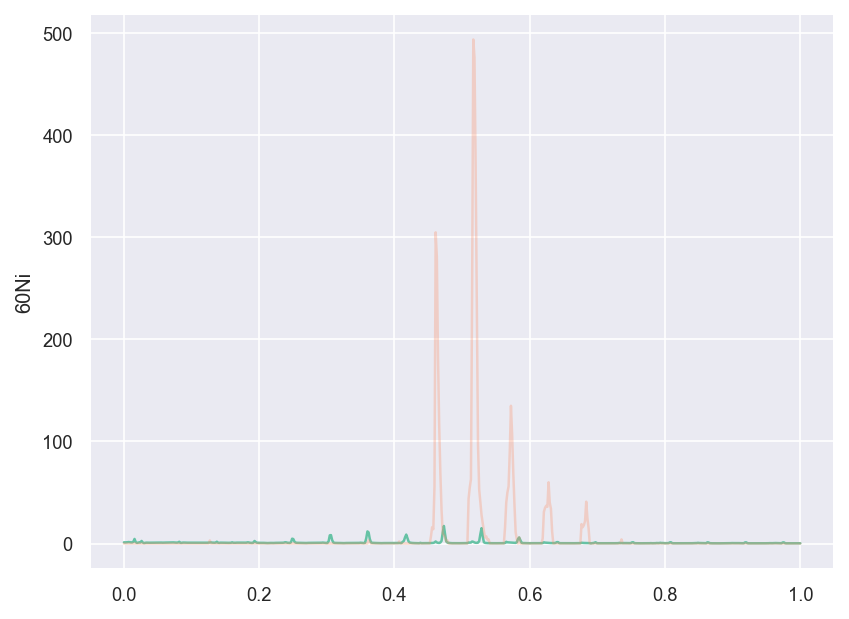

In [39]:
n_samples  = metal_df.shape[0]
linspace = np.linspace(0, 1, n_samples)

sns.lineplot(x=linspace, y=metal_column_name, data=metal_df)

# plot rpmE col
sns.lineplot(x=linspace, y=gene_name, data=prot_df, alpha=0.3)

# Join the metalloproteome data with the conversion table

In [40]:
# join the data
metal_join_df = metal_df.join(conversion_df, on="Experiment")

# filter out edges
# if x or y are 0, or x=17 or y=31, remove them.
metal_join_df = metal_join_df.filter((pl.col("x") > 1) & (pl.col("y") > 0) & (pl.col("x") < 17) & (pl.col("y") < 29))
prot_df = prot_df.filter((pl.col("x") > 1) & (pl.col("y") > 0) & (pl.col("x") < 17) & (pl.col("y") < 29))

metal_join_df

Experiment,27Al,47Ti,48Ti,51V,52Cr,55Mn,56Fe,57Fe,59Co,60Ni,63Cu,66Zn,75As,77Se,95Mo,111Cd,115In,118Sn,121Sb,182W,202Hg,208Pb,209Bi,x,y
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
"""50to100_2""",1.088476,0.089522,0.527456,0.112932,0.397705,1.42577,2.549635,2.162723,0.032594,0.760848,0.228674,0.487249,0.008842,0.170408,0.073524,0.000432,-17.657278,0.035339,0.005507,12.119874,2.914968,0.005763,4.658133,2,1
"""50to100_3""",1.338329,0.089522,0.541534,0.10537,0.412184,1.406951,2.792358,2.548397,0.035764,0.799748,0.26995,0.52867,0.022738,0.068163,0.077422,0.001512,-18.038135,0.030184,0.00494,13.791576,2.290332,0.006253,4.81875,2,2
"""50to100_4""",1.414372,0.075387,0.568446,0.100767,0.434586,1.401477,3.098119,2.797819,0.035764,0.794059,0.288256,0.543672,0.018948,0.238571,0.077675,0.001512,-18.088951,0.032425,0.00575,14.000547,2.29033,0.006881,5.461254,2,3
"""50to100_5""",1.481725,0.08481,0.65581,0.101507,0.430873,1.401327,2.865319,2.632692,0.033781,0.78268,0.287251,0.560632,0.013895,0.204489,0.076844,0.001944,-17.959603,0.030632,0.006155,12.119879,2.498543,0.006935,4.336876,2,4
"""50to100_6""",1.386128,0.065963,0.712121,0.10011,0.420353,1.385657,2.85636,2.713523,0.034522,0.766536,0.27367,0.608903,0.015158,0.272652,0.076556,0.000864,-18.098247,0.025029,0.005264,14.836425,2.342384,0.006647,3.694374,2,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""800to900_25""",0.98622,0.074156,0.180062,0.107906,0.264439,0.111622,1.008326,0.67117,0.007016,0.209949,0.17904,0.214769,0.018931,0.247222,0.07638,0.000422,-16.850606,0.022836,0.004276,12.565319,2.436734,0.003709,2.631737,16,24
"""800to900_26""",1.022011,0.078518,0.179669,0.104909,0.271269,0.110565,0.982375,0.730268,0.007956,0.219618,0.1845,0.204315,0.013883,0.317857,0.076346,0.000422,-16.749738,0.028672,0.00483,14.990214,2.55007,0.003874,3.4327,16,25
"""800to900_27""",1.103535,0.095966,0.2009,0.111613,0.284457,0.079327,1.088184,0.811526,0.007451,0.190325,0.197146,0.204632,0.020194,0.28254,0.076242,0.000633,-16.848099,0.024587,0.004989,13.226656,2.153392,0.003988,3.775978,16,26


<Axes: ylabel='60Ni'>

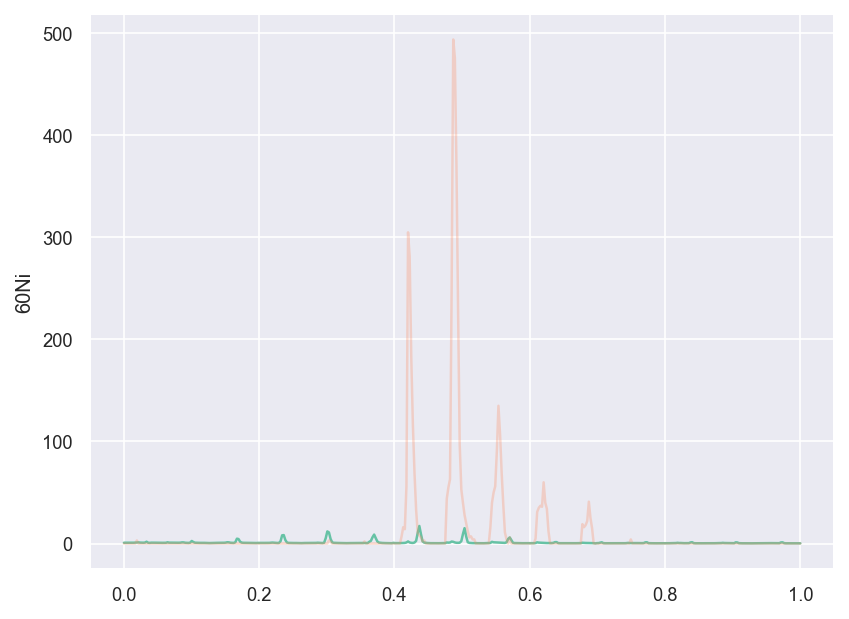

In [41]:
n_samples  = metal_join_df.shape[0]
linspace = np.linspace(0, 1, n_samples)

sns.lineplot(x=linspace, y=metal_column_name, data=metal_join_df)

# plot rpmE col
sns.lineplot(x=linspace, y=gene_name, data=prot_df, alpha=0.3)

# Import simulation data and conversion tables

In [42]:
# make protein-element mapping
elements = ["FE", "ZN", "MN", "CU", "MO", "NI"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]


# get name conversion table
gene_name_table = pl.read_csv("external_data/ecocyc_name_conversion.txt", separator="\t")

# rename cols to "Protein ID", "EcoCyc ID", "Accession Number", "Gene name"
gene_name_table.columns = ["Protein ID", "EcoCyc ID", "Accession Number", "Gene name"]

# get corresponding gene name for each protein
gene_name_table = gene_name_table.filter(pl.col("Protein ID").is_in(monomer_ids))

# make a mapping
gene_to_prot_dict = dict(zip(gene_name_table["Gene name"], gene_name_table["Protein ID"]))
prot_to_gene_dict = dict(zip(gene_name_table["Protein ID"], gene_name_table["Gene name"]))

# convert gene_names list to protein id list
detected_protein_ids = [gene_to_prot_dict[gene_name] for gene_name in gene_names if gene_name in gene_to_prot_dict]
# get indices of genes in gene dict
gene_indices = [gene_names.index(gene_name) for gene_name in gene_names if gene_name in gene_to_prot_dict]

# for each protein id, index it in the monomer_ids
detected_protein_idx = [monomer_ids.tolist().index(protein_id) for protein_id in detected_protein_ids]


# Plot unprocessed data

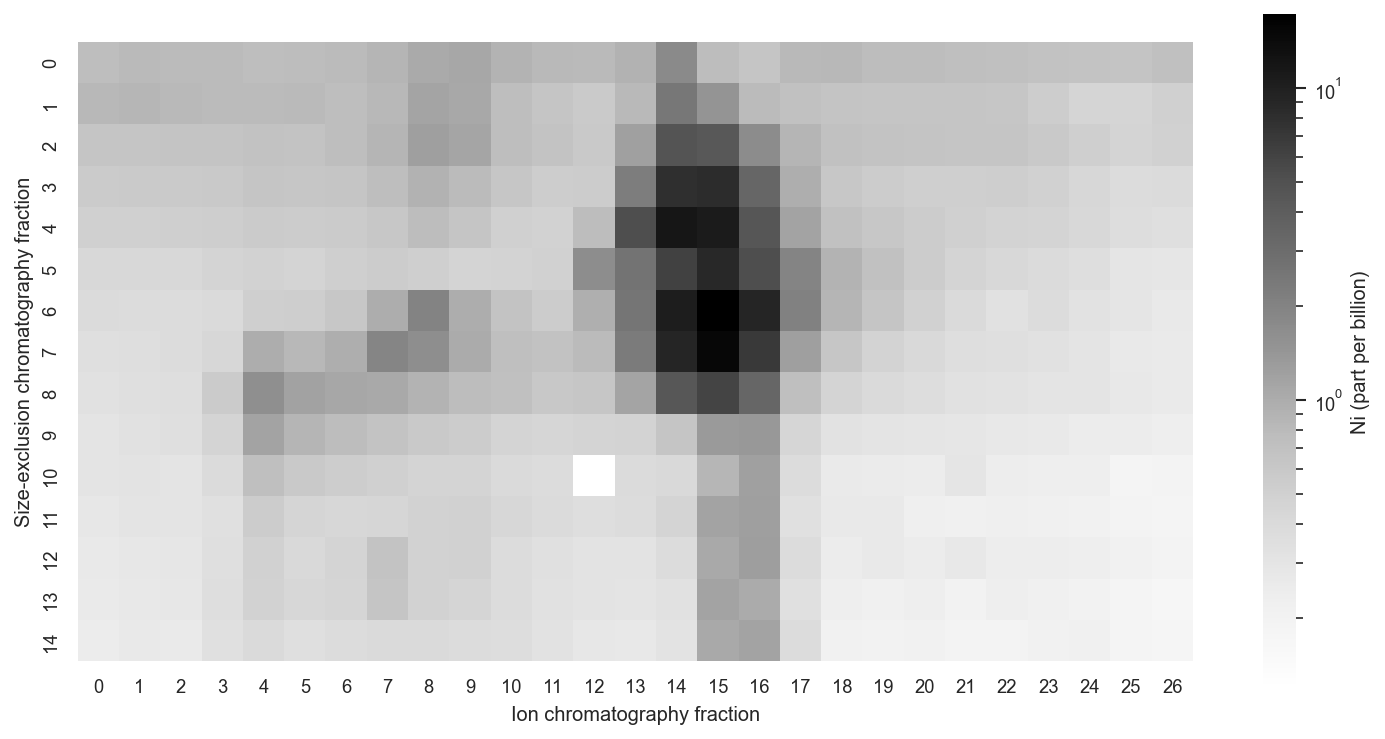

In [45]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10, 5))

# heatmap of 56Fe data against x and y
sns.heatmap(metal_join_df.pivot(metal_column_name, "x", "y", )[:, 1:], cmap="Grays", square=True, cbar=True, norm=LogNorm(), cbar_kws={'label': f'{metal_name} (part per billion)'})

# change x and y axis labels
plt.ylabel("Size-exclusion chromatography fraction")
plt.xlabel("Ion chromatography fraction")



plt.xlim([0, 27])
plt.ylim([15,0])

plt.tight_layout()

# save as png and svg
# plt.savefig("figures/zn_bare.png")
# plt.savefig("figures/zn_bare.svg")


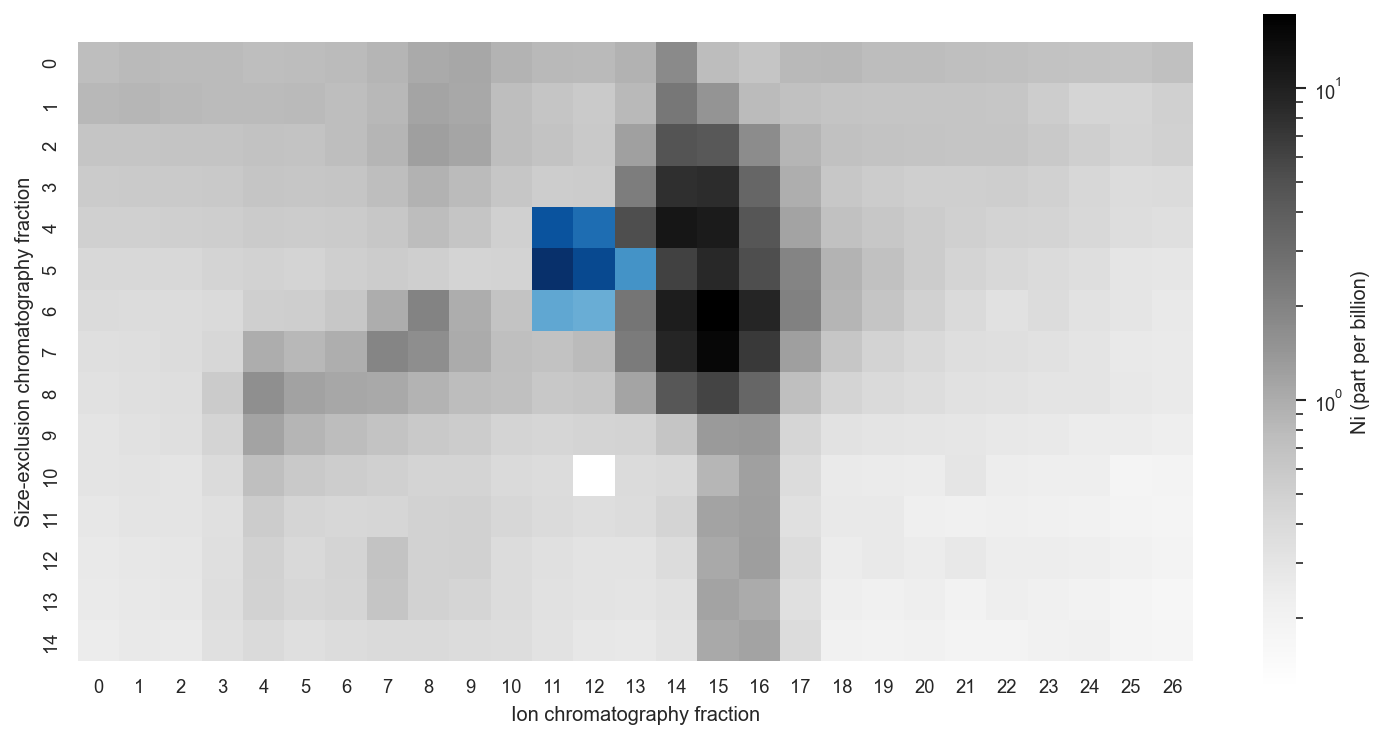

In [126]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10, 5))

# heatmap of 56Fe data against x and y
sns.heatmap(metal_join_df.pivot(metal_column_name, "x", "y", )[:, 1:], cmap="Grays", square=True, cbar=True, norm=LogNorm(), cbar_kws={'label': f'{metal_name} (part per billion)'})
sns.heatmap(prot_df.pivot(gene_name, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene_name, "x", "y", ) < 50).to_numpy()[:, 1:],
            cmap="Blues", square=True, cbar=False, vmin=0,  cbar_kws={'label': f'{gene_name} (spectral count)'})

# change x and y axis labels
plt.ylabel("Size-exclusion chromatography fraction")
plt.xlabel("Ion chromatography fraction")

plt.xlim([0, 27])
plt.ylim([15,0])

plt.tight_layout()

# save as png and svg
# plt.savefig("figures/zn_mete.png")
# plt.savefig("figures/zn_mete.svg")


# Determing gene with highest overlap

In [132]:
# metal_column_name = "66Zn"
# metal_column_name = "60Ni"
metal_column_name = "63Cu"
metal_name = ''.join([char for char in metal_column_name if not char.isdigit()])


Top 20 proteins associated with 63Cu:

Gene: leuC
Score: 3.867
Max signal: 66.0
Total signal points: 58


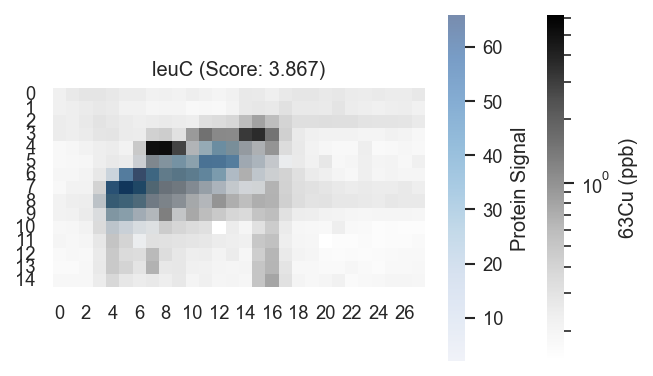


Gene: talB
Score: 3.829
Max signal: 157.0
Total signal points: 63


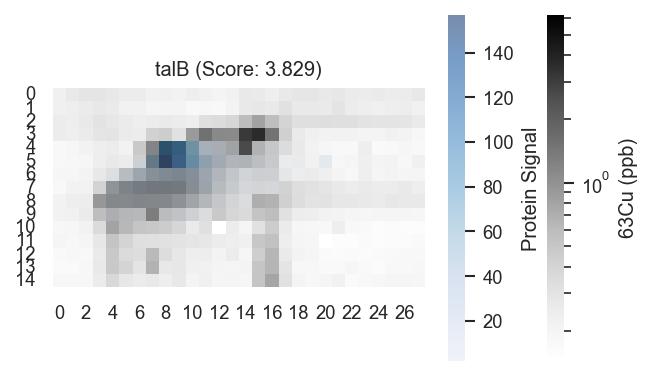


Gene: upp
Score: 3.784
Max signal: 61.0
Total signal points: 43


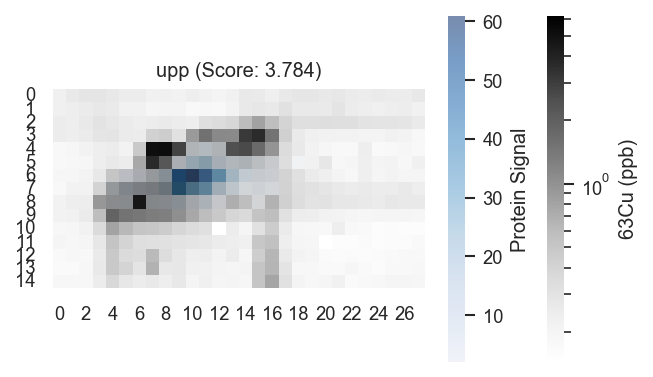


Gene: tpx
Score: 3.775
Max signal: 120.0
Total signal points: 50


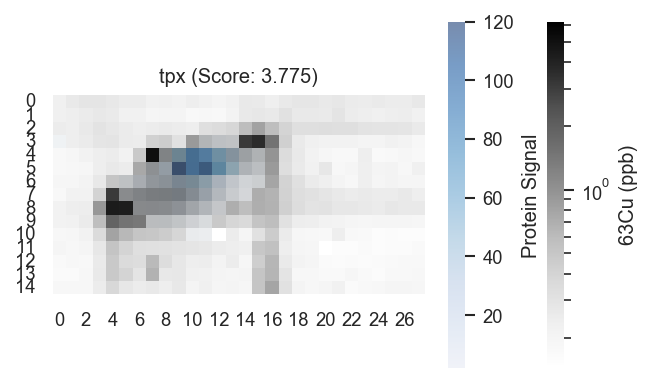


Gene: aroG
Score: 3.614
Max signal: 105.0
Total signal points: 71


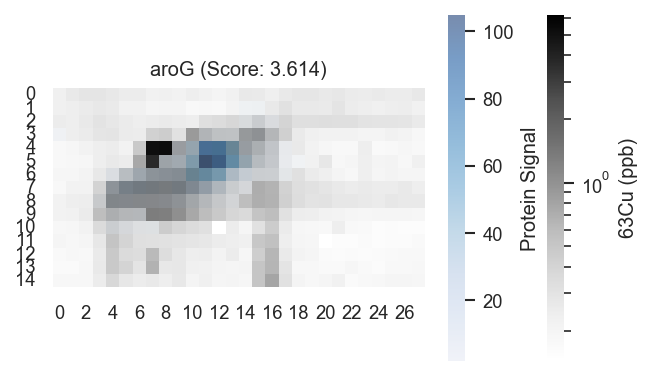


Gene: ppa
Score: 3.608
Max signal: 97.0
Total signal points: 43


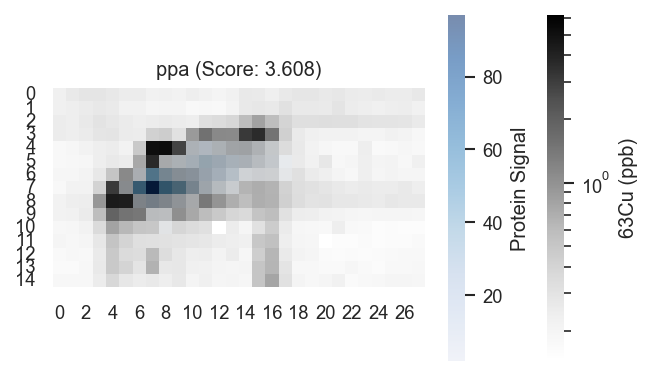


Gene: fabB
Score: 3.587
Max signal: 33.0
Total signal points: 64


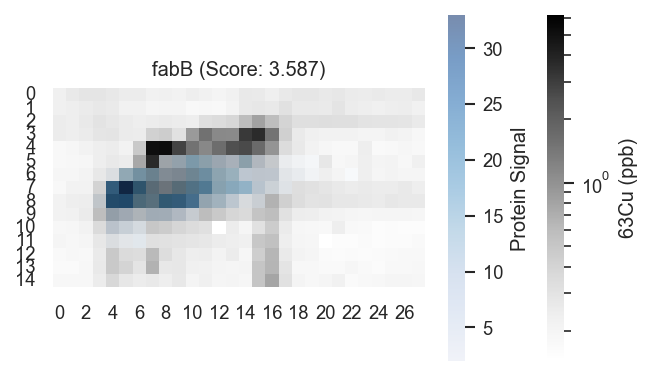


Gene: pyrC
Score: 3.584
Max signal: 58.0
Total signal points: 35


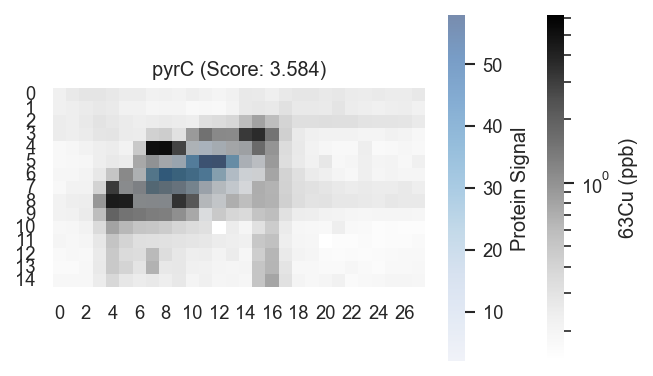


Gene: serA
Score: 3.565
Max signal: 197.0
Total signal points: 63


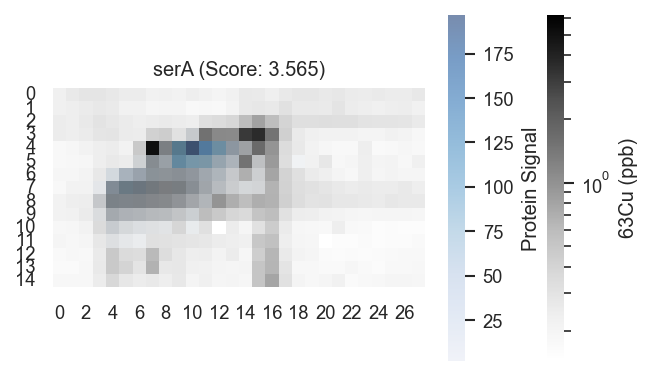


Gene: pyrG
Score: 3.537
Max signal: 42.0
Total signal points: 53


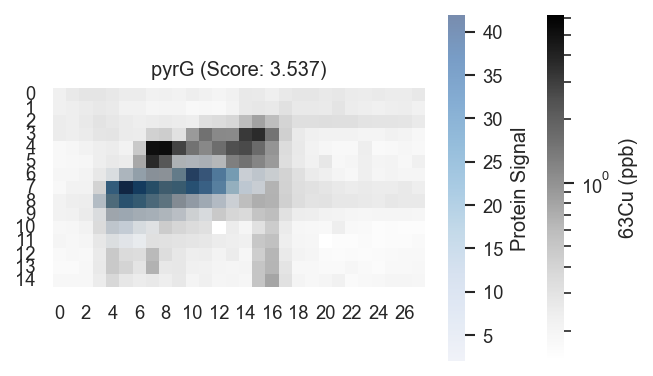


Gene: groS
Score: 3.513
Max signal: 88.0
Total signal points: 49


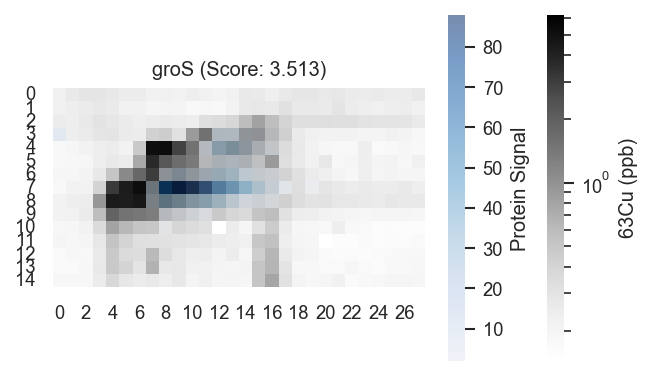


Gene: hisG
Score: 3.513
Max signal: 38.0
Total signal points: 49


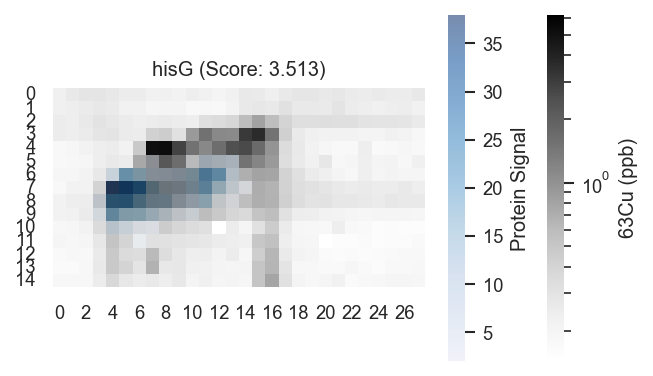


Gene: prs
Score: 3.488
Max signal: 43.0
Total signal points: 45


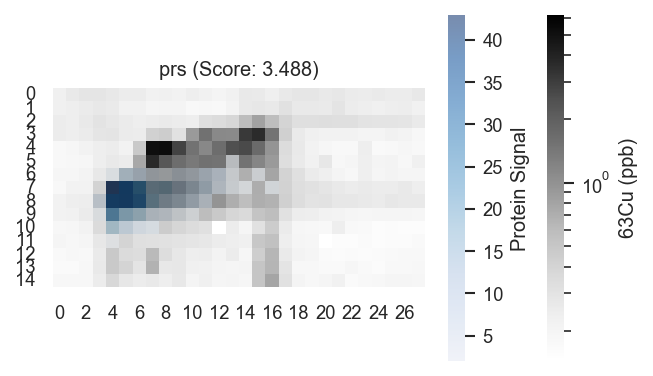


Gene: thrC
Score: 3.488
Max signal: 96.0
Total signal points: 54


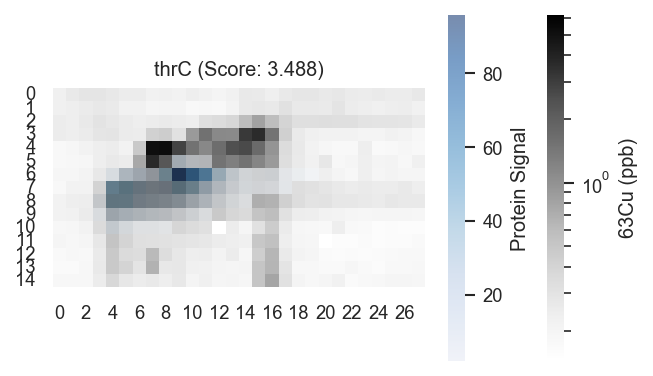


Gene: glyA
Score: 3.486
Max signal: 218.0
Total signal points: 51


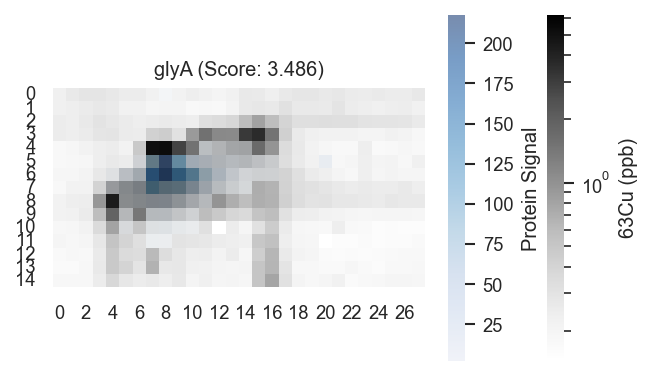


Gene: atpA
Score: 3.482
Max signal: 159.0
Total signal points: 81


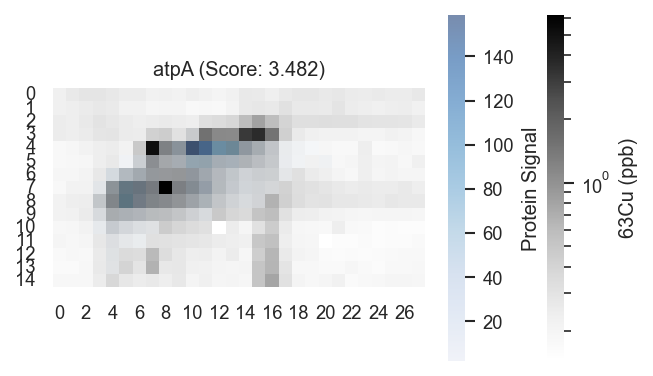


Gene: accC
Score: 3.481
Max signal: 28.0
Total signal points: 35


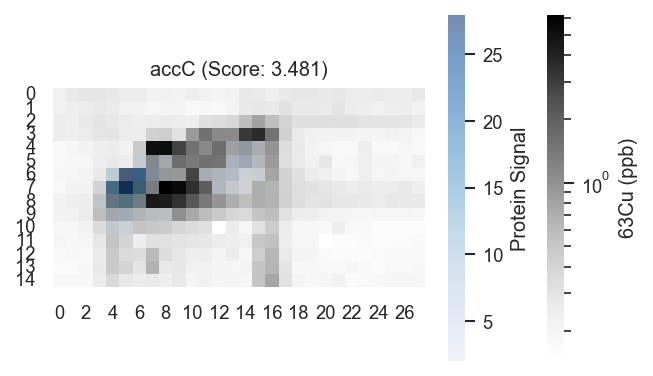


Gene: fabI
Score: 3.481
Max signal: 39.0
Total signal points: 65


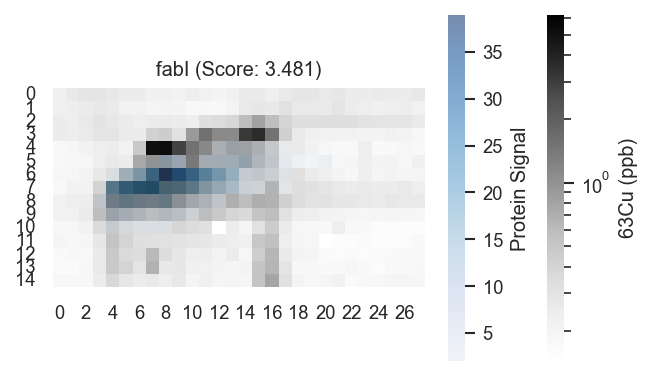


Gene: sucD
Score: 3.479
Max signal: 143.0
Total signal points: 73


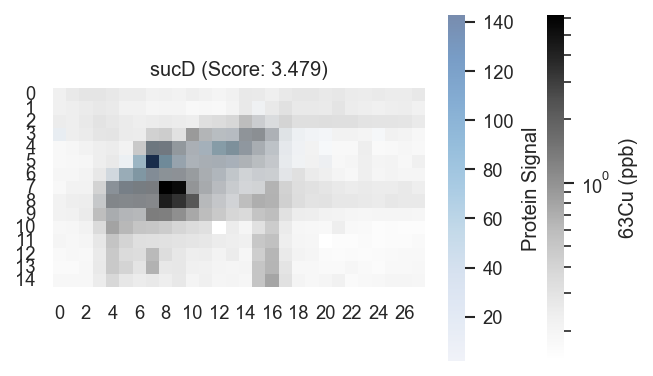


Gene: hisD
Score: 3.441
Max signal: 52.0
Total signal points: 37


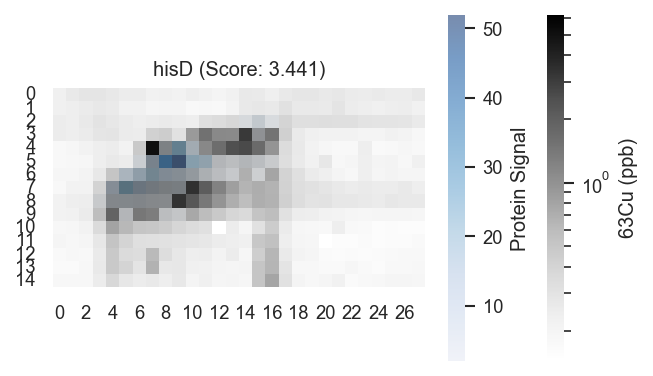

[{'gene': 'leuC',
  'score': 3.8666303347381823,
  'max_signal': 66,
  'total_points': 58},
 {'gene': 'talB',
  'score': 3.828812997378745,
  'max_signal': 157,
  'total_points': 63},
 {'gene': 'upp',
  'score': 3.784189633918261,
  'max_signal': 61,
  'total_points': 43},
 {'gene': 'tpx',
  'score': 3.7745526074153526,
  'max_signal': 120,
  'total_points': 50},
 {'gene': 'aroG',
  'score': 3.6140840442389197,
  'max_signal': 105,
  'total_points': 71},
 {'gene': 'ppa',
  'score': 3.6081808137360163,
  'max_signal': 97,
  'total_points': 43},
 {'gene': 'fabB',
  'score': 3.587364060066563,
  'max_signal': 33,
  'total_points': 64},
 {'gene': 'pyrC',
  'score': 3.58351893845611,
  'max_signal': 58,
  'total_points': 35},
 {'gene': 'serA',
  'score': 3.564756928594004,
  'max_signal': 197,
  'total_points': 63},
 {'gene': 'pyrG',
  'score': 3.5374009469532246,
  'max_signal': 42,
  'total_points': 53},
 {'gene': 'groS',
  'score': 3.51283698446609,
  'max_signal': 88,
  'total_points': 

In [133]:
def calculate_overlap_score(protein_data, metal_data, min_protein_points=10, threshold_protein=2, threshold_metal=None):
    if threshold_metal is None:
        threshold_metal = metal_data.mean()
    
    # Create boolean masks for significant signals
    protein_mask = protein_data > threshold_protein
    metal_mask = metal_data > threshold_metal
    
    # Check if there's enough protein signal
    if protein_mask.sum() < min_protein_points:
        return 0
    
    overlap = (protein_mask & metal_mask).sum()
    score = (overlap / protein_mask.sum()) * np.log1p(protein_mask.sum())
    
    if overlap == 0: 
        return 0
    if protein_data.max() < 10:
        return 0
    if (protein_data > threshold_protein).sum() < min_protein_points:  #
        return 0
        
    return score

def find_metal_associated_proteins(metal_column_name, top_n=20):
    metal_matrix = metal_join_df.pivot(metal_column_name, "x", "y")[:, 1:].to_numpy()
    
    results = []
    for gene in gene_names:
        protein_matrix = prot_df.pivot(gene, "x", "y")[:, 1:].to_numpy()
        
        if protein_matrix.size == 0 or protein_matrix.max() == 0:
            continue
            
        score = calculate_overlap_score(protein_matrix, metal_matrix)
        
        if score > 0:
            results.append({
                'gene': gene,
                'score': score,
                'max_signal': protein_matrix.max(),
                'total_points': (protein_matrix > 2).sum()
            })
    
    results.sort(key=lambda x: x['score'], reverse=True)
    
    # Print results with visualization for top hits
    print(f"\nTop {top_n} proteins associated with {metal_column_name}:")
    for result in results[:top_n]:
        print(f"\nGene: {result['gene']}")
        print(f"Score: {result['score']:.3f}")
        print(f"Max signal: {result['max_signal']:.1f}")
        print(f"Total signal points: {result['total_points']}")
        
        if result['max_signal'] > 0:  # Additional check
            plt.figure(figsize=(5, 3))
            
            sns.heatmap(metal_join_df.pivot(metal_column_name, "x", "y")[:, 1:], 
                cmap="Grays", 
                square=True, 
                cbar=True, 
                norm=LogNorm(), 
                cbar_kws={'label': f'{metal_column_name} (ppb)'})
            
            protein_matrix = prot_df.pivot(result['gene'], "x", "y")[:, 1:].to_numpy()
            sns.heatmap(protein_matrix, 
                mask=(protein_matrix < 2),  # Only show strong signals
                cmap="Blues", 
                square=True, 
                cbar=True,
                alpha=0.5,
                cbar_kws={'label': 'Protein Signal'})
            
            plt.title(f"{result['gene']} (Score: {result['score']:.3f})")
            plt.show()
        
    return results[:top_n]

find_metal_associated_proteins(metal_column_name)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/timjing/Documents/vivarium-ecoli/notebooks/cofactors/figures/metal_splashes.png'

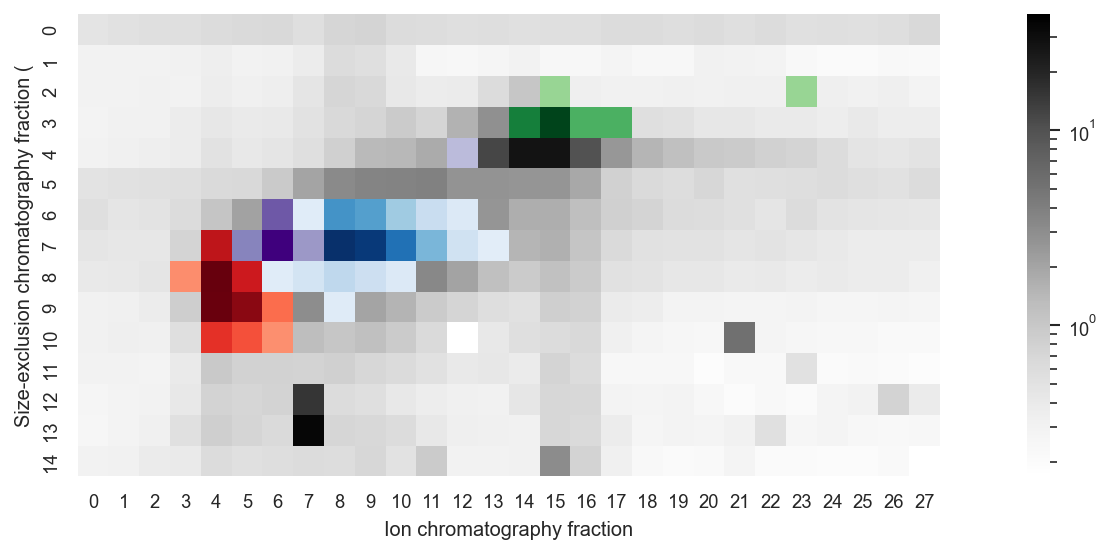

In [85]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(15, 4))

# heatmap of 56Fe data against x and y
sns.heatmap(metal_join_df.pivot("66Zn", "x", "y", )[:, 1:], cmap="Grays", square=True, cbar=True, norm=LogNorm())
sns.heatmap(prot_df.pivot("metE", "x", "y", )[:, 1:], mask=(prot_df.pivot("metE", "x", "y", ) < 50).to_numpy()[:, 1:], 
            cmap="Blues", square=True, cbar=False, vmin=0)
sns.heatmap(prot_df.pivot("rpmE", "x", "y", )[:, 1:], mask=(prot_df.pivot("rpmE", "x", "y", ) < 1).to_numpy()[:, 1:], 
            cmap="Greens", square=True, vmin=0, cbar=False)
sns.heatmap(prot_df.pivot("rpoC", "x", "y", )[:, 1:], mask=(prot_df.pivot("rpoC", "x", "y", ) < 100).to_numpy()[:, 1:], 
            cmap="Reds", square=True, vmin=0, cbar=False)
sns.heatmap(prot_df.pivot("pyrI", "x", "y", )[:, 1:], mask=(prot_df.pivot("pyrI", "x", "y", ) < 80).to_numpy()[:, 1:], 
            cmap="Purples", square=True, vmin=0, cbar=False)

# change x and y axis labels
plt.ylabel("Size-exclusion chromatography fraction (")
plt.xlabel("Ion chromatography fraction")

# make xticklabels integers 2-18
# plt.xticks(np.arange(1, 14, 2))
# plt.xlim([0, 28])
# plt.ylim([0, 14])

# save as png and svg
plt.savefig("figures/metal_splashes.png")
plt.savefig("figures/metal_splashes.svg")


# Plot grid of heatmaps

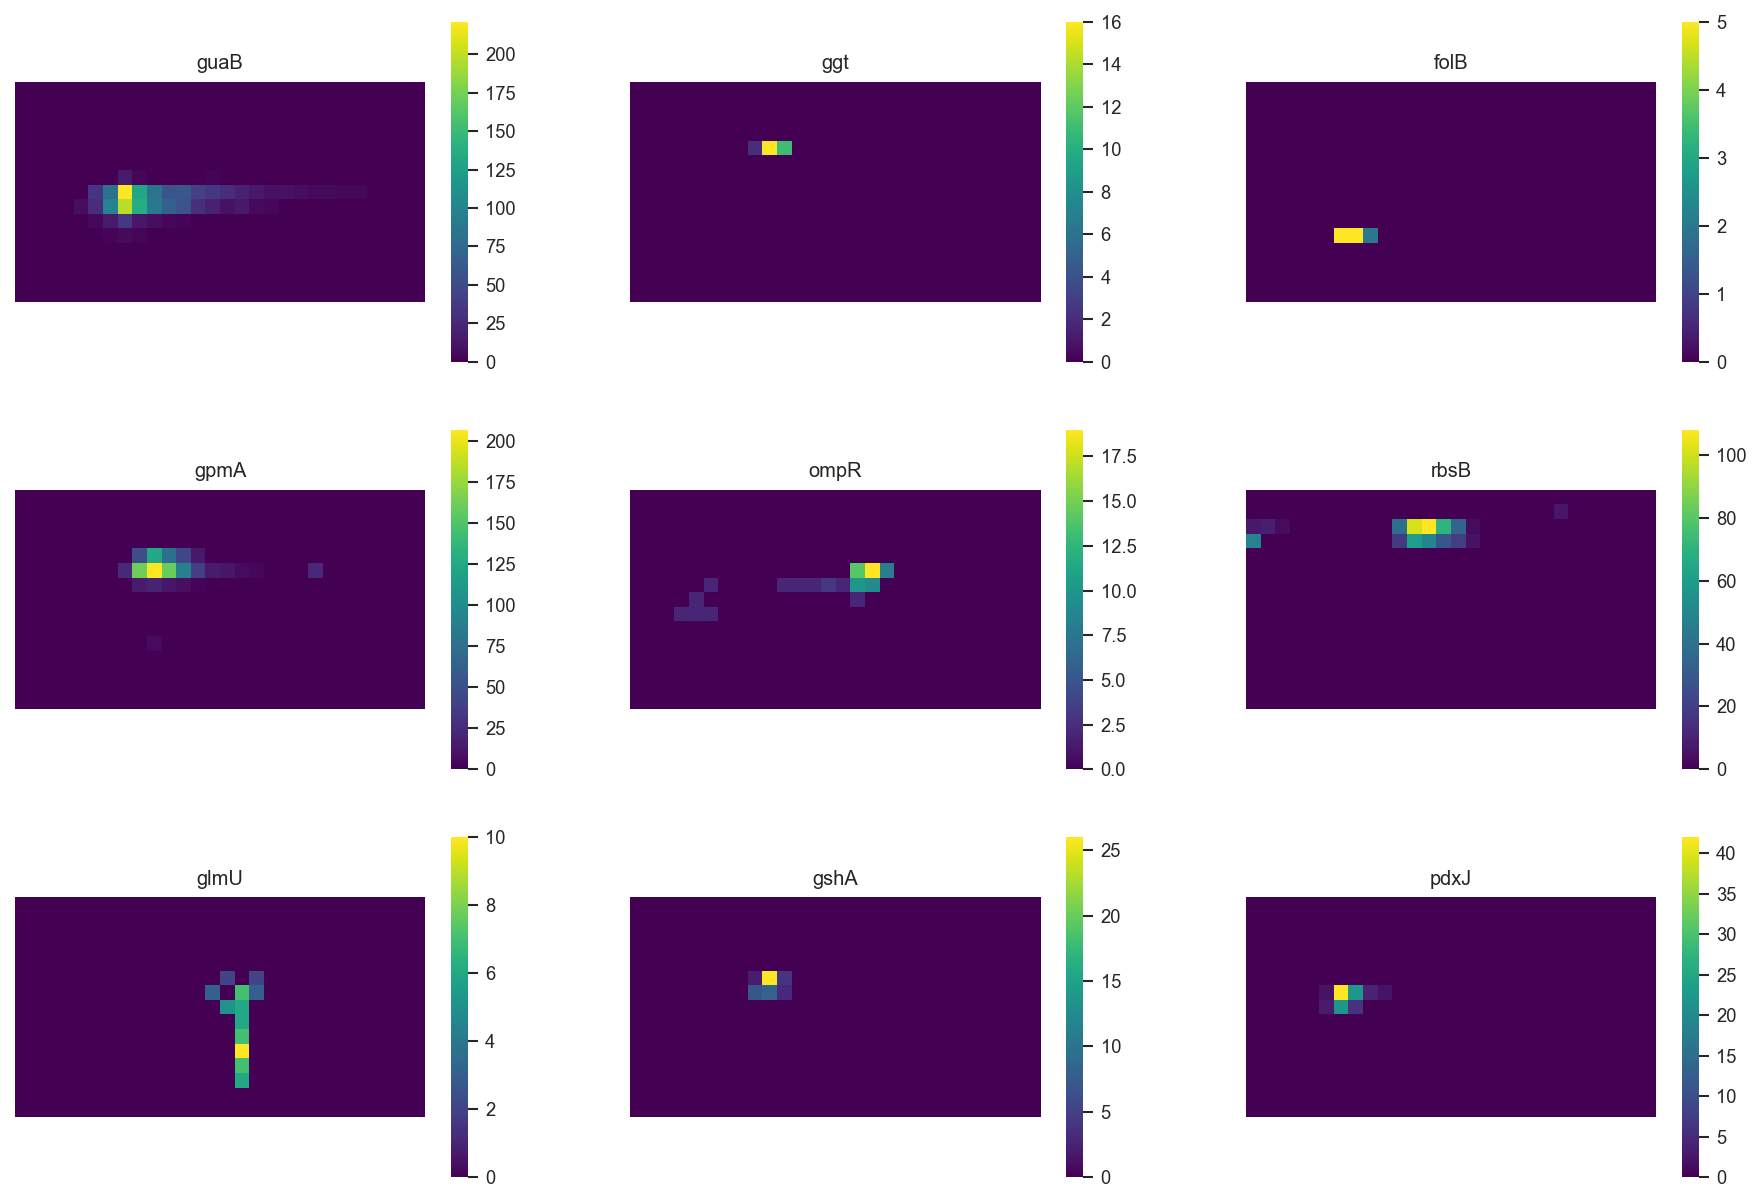

In [18]:
# for 9 random proteins, plot a grid of small heatmaps
random_proteins = np.random.choice(gene_names, 9)

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
for i, ax in enumerate(axs.flatten()):
    sns.heatmap(prot_df.pivot(random_proteins[i], "x", "y", )[:, 1:], cmap="viridis", square=True, cbar=True, ax=ax)
    ax.set_title(random_proteins[i])
    ax.set_xticks([])
    ax.set_yticks([])

    ## Filter out edges

In [19]:
# For each protein, pivot and do some filtering

for protein in gene_names:
    prot_pivot = prot_df.pivot(protein, "x", "y", ).to_numpy()[:, 1:]

    # create boolean array
    prot_mask = prot_pivot > 0

    # find number of neighbours per well
    footprint = np.array([[1,1,1],
                          [1,0,1],
                          [1,1,1]])

    f = lambda x: x.sum()

    results = ndimage.generic_filter(prot_mask, f, footprint=footprint, mode="constant", cval=0)

    # get AND of the two
    prot_pivot_true_mask = prot_mask & results

    # dont zero if it would remove all the data
    if prot_pivot_true_mask.sum() > 0:
        prot_pivot[~prot_pivot_true_mask] = 0

    # set column as flattened pivot
    prot_df = prot_df.with_columns(pl.Series(name=protein, values=prot_pivot.flatten()))



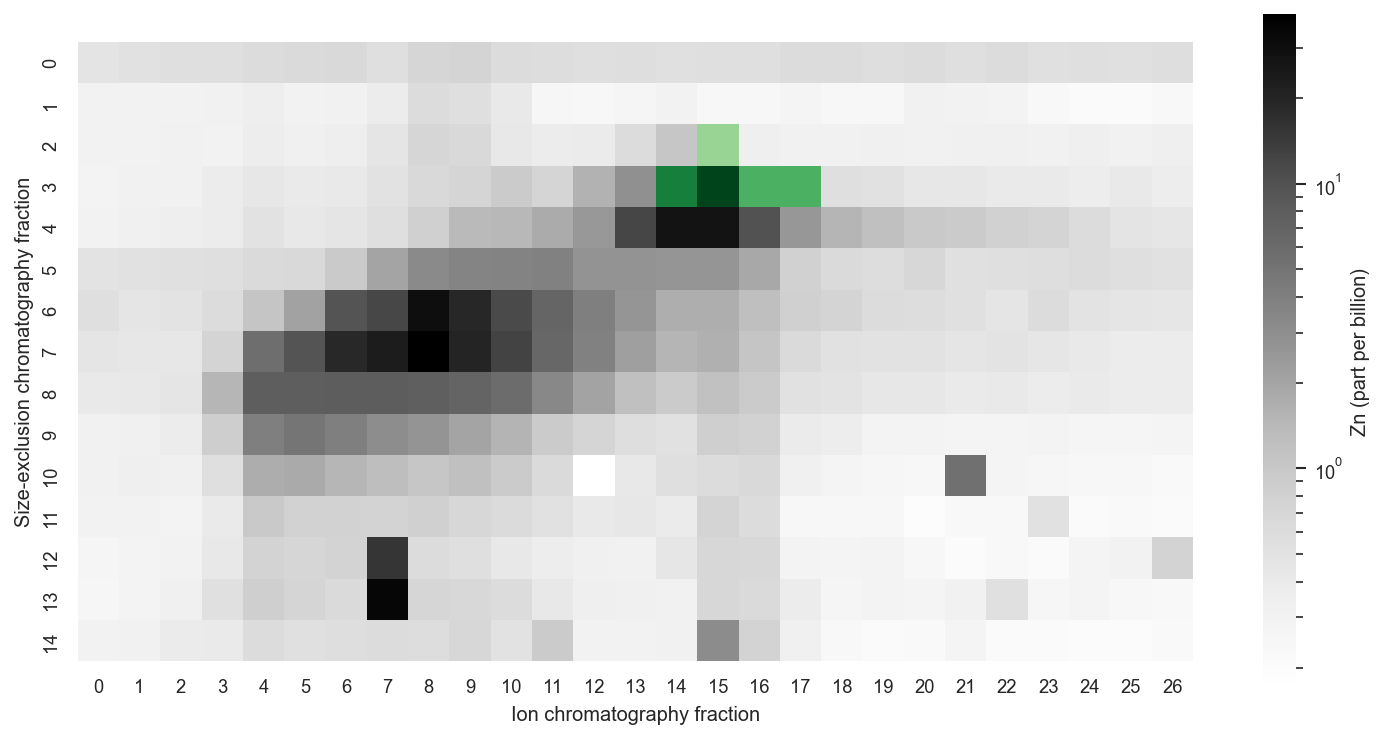

In [20]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10, 5))

# heatmap of 56Fe data against x and y
sns.heatmap(metal_join_df.pivot("66Zn", "x", "y", )[:, 1:], cmap="Grays", square=True, cbar=True, norm=LogNorm(), cbar_kws={'label': 'Zn (part per billion)'})
sns.heatmap(prot_df.pivot("rpmE", "x", "y", )[:, 1:], mask=(prot_df.pivot("rpmE", "x", "y", ) < 1).to_numpy()[:, 1:],
            cmap="Greens", square=True, cbar=False, vmin=0,  cbar_kws={'label': 'RpmE (spectral count)'})

# change x and y axis labels
plt.ylabel("Size-exclusion chromatography fraction")
plt.xlabel("Ion chromatography fraction")

plt.xlim([0, 27])
plt.ylim([15,0])

plt.tight_layout()

# save as png and svg
# plt.savefig("figures/zn_rpme.png")
# plt.savefig("figures/zn_rpme.svg")


# Check out some data

In [21]:
prot_df.filter((pl.col("y") == 7) & (pl.col("x") == 13)).melt(id_vars=["Experiment", "x", "y"], variable_name="Gene", value_name="Intensity")

Experiment,x,y,Gene,Intensity
str,i64,i64,str,i64
"""600to650_8""",13,7,"""tufB""",44
"""600to650_8""",13,7,"""rplC""",8
"""600to650_8""",13,7,"""rpsE""",18
"""600to650_8""",13,7,"""fliC""",37
"""600to650_8""",13,7,"""groL""",55
…,…,…,…,…
"""600to650_8""",13,7,"""ygaC""",0
"""600to650_8""",13,7,"""ycaK""",0
"""600to650_8""",13,7,"""miaA""",0


<Figure size 1500x750 with 0 Axes>

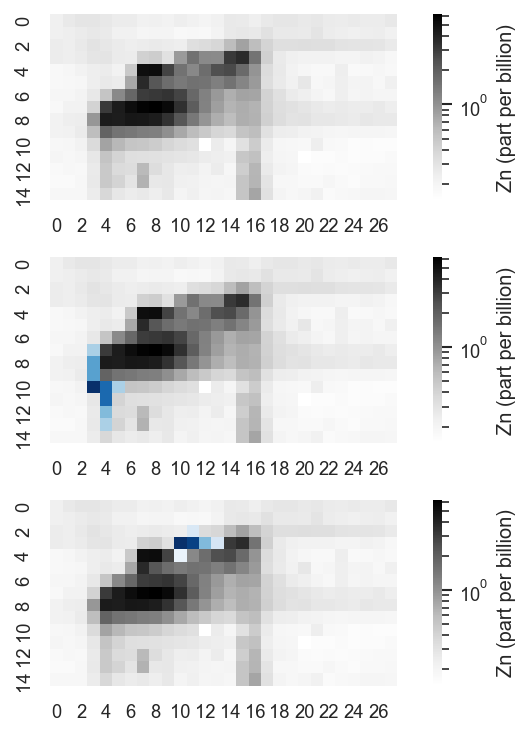

In [22]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10, 5))

f, ax = plt.subplots(3,1, figsize=(5, 5))

gene = "cyoA"
gene2 = "cueO"
metal = "63Cu"

# heatmap of 56Fe data against x and y
sns.heatmap(metal_join_df.pivot(metal, "x", "y", )[:, 1:], cmap="Grays", square=True, cbar=True,
            norm=LogNorm(), cbar_kws={'label': 'Zn (part per billion)'}, ax=ax[0])

sns.heatmap(metal_join_df.pivot(metal, "x", "y", )[:, 1:], cmap="Grays", square=True,
            cbar=True, norm=LogNorm(), cbar_kws={'label': 'Zn (part per billion)'}, ax=ax[1])
sns.heatmap(prot_df.pivot(gene, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene, "x", "y", ) < 1).to_numpy()[:, 1:],
            cmap="Blues", square=True, cbar=False, vmin=0,  cbar_kws={'label': f'{gene} (spectral count)'}, ax=ax[1])

sns.heatmap(metal_join_df.pivot(metal, "x", "y", )[:, 1:], cmap="Grays", square=True,
            cbar=True, norm=LogNorm(), cbar_kws={'label': 'Zn (part per billion)'}, ax=ax[2])
sns.heatmap(prot_df.pivot(gene2, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene2, "x", "y", ) < 1).to_numpy()[:, 1:],
            cmap="Blues", square=True, cbar=False, vmin=0,  cbar_kws={'label': f'{gene} (spectral count)'}, ax=ax[2])

# # change x and y axis labels
# ax=ax[0].ylabel("Size-exclusion chromatography fraction")
# ax=ax[0].xlabel("Ion chromatography fraction")
#
#
#
# ax=ax[0].xlim([0, 27])
# ax=ax[0].ylim([15,0])

plt.tight_layout()

# save as png and svg
# plt.savefig("figures/zn_bare.png")
# plt.savefig("figures/zn_bare.svg")


# Identify protein responsible for unknown peak

In [25]:
description_df = prot_df_raw.select(["Identified Proteins (1235)", "Accession Number"])

description_df = gene_df.join(description_df, on="Accession Number")

# rename Identified Proteins (1235) to "Description"
description_df = description_df.rename({"Identified Proteins (1235)": "Description", "Gene Name": "Gene"})

# Add new column, "is unknown function", 
description_df = description_df.with_columns(pl.Series(name="is unknown function", values=[1 if desc.startswith("y") else 0 for desc in description_df["Gene"]]))

description_df.filter(pl.col("is unknown function") == 1)

Accession Number,Gene,Description,is unknown function
str,str,str,i64
"""AAC74534.1""","""yncE""","""ATP-binding protein, periplasm…",1
"""AAC74287.1""","""ychF""","""catalase inhibitor protein; AT…",1
"""AAC74934.1""","""yebC""","""UPF0082 family protein [Escher…",1
"""AAC74850.2""","""yeaD""","""D-hexose-6-phosphate epimerase…",1
"""AAC76668.1""","""yicC""","""UPF0701 family protein [Escher…",1
…,…,…,…
"""AAC74609.1""","""ydeI""","""hydrogen peroxide resistance O…",1
"""AAC74504.2""","""ydcI""","""putative DNA-binding transcrip…",1
"""AAC74995.1""","""yedD""","""lipoprotein [Escherichia coli …",1
